The assignment was to take the dataset from https://www.kaggle.com/anthonypino/melbourne-housing-market#Melbourne_housing_FULL.csv and build a model that could accurately (~80%) estimate the value of a house, ideally in a way that allows for better understanding of what goes into making a house valuable.

#### Assignment text:
Using this Kaggle data create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

## Importing code

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import math
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from timeit import default_timer as timer

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

## Uploading & subsetting data

In [2]:
# Upload datasets
housing_full_basedata = pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
# Sample smaller chunks of the datasets to speed up testing models
all_data_full = housing_full_basedata
half_data_full = housing_full_basedata.sample(frac=.5, random_state=2, axis=0)
quarter_data_full = housing_full_basedata.sample(frac=.25, random_state=2, axis=0)
tenth_data_full = housing_full_basedata.sample(frac=.1, random_state=2, axis=0)
hundreth_data_full = housing_full_basedata.sample(frac=.01, random_state=2, axis=0)

In [4]:
# create a report function that can be used for any model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

def accuracy_report(testing_X, testing_Y, model, cv):
    y_prediction = model.predict(testing_X)
    print('Explained Variance Score: ' + str(explained_variance_score(testing_Y.values, y_prediction)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(testing_Y.values, y_prediction)))
    print('Mean Squared Error: ' + str(mean_squared_error(testing_Y.values, y_prediction)))
#    print('Mean Squared Log Error: ' + str(mean_squared_log_error(testing_Y.values, y_prediction)))
    print('Median Absolute Error: ' + str(median_absolute_error(testing_Y.values, y_prediction)))
    print('R-squared: ' + str(r2_score(testing_Y.values, y_prediction)))
    
    # Sometimes we don't want to spend the processor time calculating the cross-valuation, 
    # so we need a way to toggle it.
    if cv == 1:
        print(" ")
        print('Model cross-valuation:')
        print(sklearn.model_selection.cross_val_score(model, testing_X, testing_Y, cv = 5))
    return

#    auc = roc_auc_score(testing_Y.values, y_prediction)
#    print('AUC score: %.3f'% auc)


## Cleaning data

I am creating functions to allow for repeated processing of different data sets (or different samples of the same data set) without using up a massive number of lines or running the risk of the data cleaning sections of the notebook being different due to a forgetful programmer going in and changing one but not another.  With a standardized set of functions, they can all be put through the *same* processing, without worrying as much about human error.

In [5]:
# create a function to do preliminary cleaning of the data

def basic_clean(working_df):
    
    # Remove any rows with NaN in the Price column, as they're useless for the purposes of this model
    working_df.dropna(subset=['Price'], inplace=True)

    # drop the columns with no impact on the house's value
    working_df.drop(['Address', 'Lattitude', 'Longtitude', 'SellerG'], axis=1, inplace=True)

    # Remove any rows with NaN in the Bedroom2 or Bathroom column
    working_df.dropna(subset=['Bedroom2', 'Bathroom'], inplace=True)
    
    # Cut off the last four digits of the 'date sold' column and subtract Yearbuilt to give an age at sale
    working_df['age_when_sold'] = pd.to_numeric(working_df['Date'].str[-4:]) - working_df['YearBuilt']

    # Drop 'date sold' and 'date constructed' columns
    working_df.drop(['YearBuilt', 'Date'], axis=1, inplace=True)
    
    return(working_df)


In [6]:
# Make a function that fills in NaN values based on the average of properties within a geographic region.
# The regions used to calculate the average progressively increase in size, to ensure that as many NaNs are
# filled in while also ensuring that averages aren't distorted by clumping disparate suburbs or postcodes together.

def fillin_averages(working_df):

    # separate out the nonnumeric and postcode columns, as they'll be removed by this process
    working_df_nonnumeric = working_df[['Suburb', 'CouncilArea', 'Regionname', 'Type', 'Method',]].copy()
    postcode_df = working_df[['Postcode']].copy()
    
    # fill in NaN based on the average of the respective suburb
    grouped = working_df.groupby('Suburb')
    transformed = grouped.transform(lambda x: x.fillna(x.mean()))
    working_df = pd.concat([working_df_nonnumeric, transformed], axis=1)

    # fill in NaN based on the average of the respective postal code
    grouped = working_df.groupby('Postcode')
    transformed = grouped.transform(lambda x: x.fillna(x.mean()))
    working_df = pd.concat([working_df_nonnumeric, transformed], axis=1)

    # fill in NaN based on the average of the respective council area
    grouped = working_df.groupby('CouncilArea')
    transformed = grouped.transform(lambda x: x.fillna(x.mean()))
    working_df = pd.concat([working_df_nonnumeric, transformed], axis=1)

    # fill in NaN based on the average of the respective region
    grouped = working_df.groupby('Regionname')
    transformed = grouped.transform(lambda x: x.fillna(x.mean()))
    working_df = pd.concat([working_df_nonnumeric, transformed], axis=1)

    # add Postcode back in
    working_df = pd.concat([postcode_df, working_df], axis=1)
    
    return(working_df)


In [7]:
# Create a function to add in columns with the average prices for each of the geographic regions

def add_average_prices(working_df):

    # Creating a column containing the average price of each property's respective suburb
    suburb_average_price = working_df['Price'].groupby(working_df['Suburb']).mean()
    suburb_average_price = suburb_average_price.to_dict()

    # Creating a column containing the average price of each property's respective Postal Code
    postal_average_price = working_df['Price'].groupby(working_df['Postcode']).mean()
    postal_average_price = postal_average_price.to_dict()

    # Creating a column containing the average price of each property's respective Council Area
    council_average_price = working_df['Price'].groupby(working_df['CouncilArea']).mean()
    council_average_price = council_average_price.to_dict()

    # Creating a column containing the average price of each property's respective Region
    region_average_price = working_df['Price'].groupby(working_df['Regionname']).mean()
    region_average_price = region_average_price.to_dict()
    
    # Add in the averages to working_df
    working_df['suburb_average_price'] = working_df['Suburb']
    working_df['suburb_average_price'] = working_df['suburb_average_price'].replace(to_replace=suburb_average_price)

    working_df['postal_average_price'] = working_df['Postcode']
    working_df['postal_average_price'] = working_df['postal_average_price'].replace(to_replace=postal_average_price)
    
    working_df['council_average_price'] = working_df['CouncilArea']
    working_df['council_average_price'] = working_df['council_average_price'].replace(to_replace=council_average_price)

    working_df['region_average_price'] = working_df['Regionname']
    working_df['region_average_price'] = working_df['region_average_price'].replace(to_replace=region_average_price)

    return(working_df)



In [8]:
# Create a function to clean out any rows with values in the specified columns larger than the specified amount

def outlier_cleaner(working_df, feature, outlier_limit):
    drop_feature_outliers = working_df.loc[working_df[feature] > outlier_limit]
    working_df.drop(drop_feature_outliers.index, inplace=True)
    return(working_df)

# Create a function that will clear out the outliers for various columns, 
# based on information gathered from visulaizations and sifting through the data

def clean_outliers(working_df):
    outlier_cleaner(working_df, 'Price', 6500000)
    outlier_cleaner(working_df, 'age_when_sold', 200)
    outlier_cleaner(working_df, 'BuildingArea', 800)
    outlier_cleaner(working_df, 'Landsize', 12500)
    outlier_cleaner(working_df, 'Bedroom2', 9)
    outlier_cleaner(working_df, 'Car', 9)
    outlier_cleaner(working_df, 'Rooms', 9)
    outlier_cleaner(working_df, 'Bathroom', 6)

    return(working_df)



In [9]:
# Create a function that will make multiple (hopefully) useful PCAs for the models to chew on

def features_PCAs(working_df):

    # calculate PCA based on size of the property (Rooms, Bedroom2, Bathroom, Car, Landsize, BuildingArea)
    home_size = working_df[['Rooms', 
                            'Bedroom2', 
                            'Bathroom', 
                            'Car', 
                            'Landsize', 
                            'BuildingArea'
                           ]]
    pca = PCA(n_components=4)
    home_size_PCA = pca.fit_transform(home_size)

    # calculate PCA based on average geographic value (suburb_average_price, etc.)
    avg_values = working_df[['suburb_average_price',
                        'postal_average_price',
                        'council_average_price',
                        'region_average_price']]
    pca = PCA(n_components=2)
    avg_values_PCA = pca.fit_transform(avg_values)

    # join the PCAs up with the working_df
    working_df['home_size_PCA_1'] = home_size_PCA[:,0]
    working_df['home_size_PCA_2'] = home_size_PCA[:,1]
    working_df['home_size_PCA_3'] = home_size_PCA[:,2]
    working_df['home_size_PCA_4'] = home_size_PCA[:,3]
    working_df['avg_values_PCA_1'] = avg_values_PCA[:,0] 
    working_df['avg_values_PCA_2'] = avg_values_PCA[:,1] 
    
    # Drop the features that the PCAs were built on
    working_df.drop(['suburb_average_price', 
                     'postal_average_price',
                     'council_average_price', 
                     'region_average_price',
                     'Rooms', 
                     'Bedroom2', 
                     'Bathroom', 
                     'Car', 
                     'Landsize', 
                     'BuildingArea'
                    ], axis=1, inplace=True)

    return(working_df)

In [10]:
# Make a function adding in other features and doing a final clean up of the data

def addin_features(working_df):

    # Make a new binary feature for if a property has no land, signifying it's a condo or apartment
    working_df.loc[working_df.Landsize == 0, 'condo_or_apt'] = 1
    working_df.loc[working_df.Landsize != 0, 'condo_or_apt'] = 0
    
    # Turn Postcode into a str feature, so that it can get separated out by get_dummies, if applied
    working_df['Postcode'] = working_df['Postcode'].astype(str)
    
    # clean any remaining NaN out of the dataframe.
    working_df = working_df.dropna()

    return(working_df)


## Visualisations & Data analysis

### Original Variable Descriptions

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

Date: Date sold

Distance: Distance from CBD in Kilometres

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

### Correlation Matrices

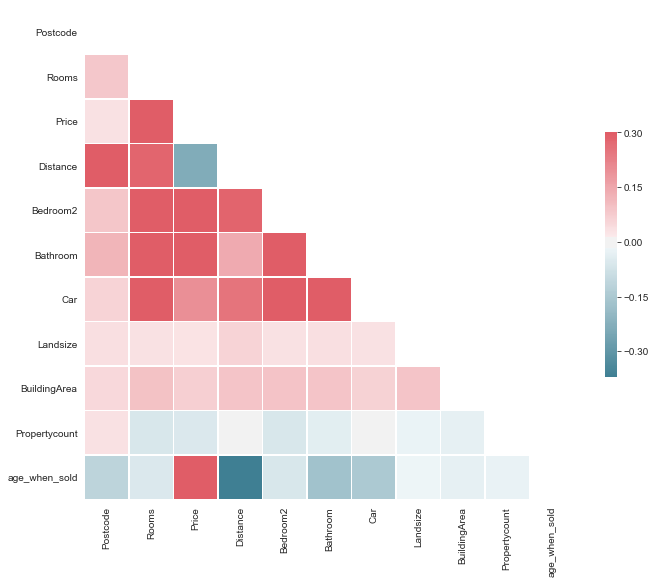

In [20]:
# Compute the correlation matrix for the original df, with only the most basic cleaning functions applied
working_df = all_data_full.copy()
working_df = basic_clean(working_df)
working_df = fillin_averages(working_df)

corr = working_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

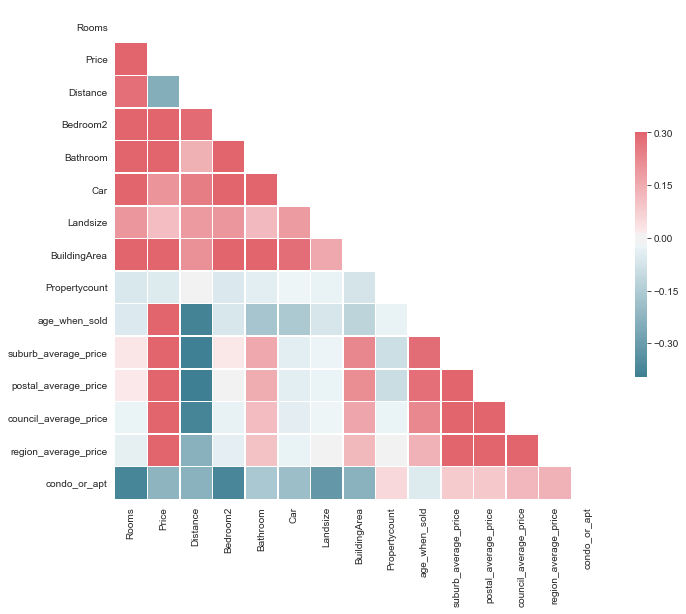

In [21]:
# Compute the correlation matrix for the cleaned and processed (except for adding in PCAs) working_df
working_df = all_data_full.copy()

# Run the data-preparation functions on it.
working_df = basic_clean(working_df)
working_df = clean_outliers(working_df)
working_df = fillin_averages(working_df)
working_df = add_average_prices(working_df)
working_df = addin_features(working_df)

corr = working_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

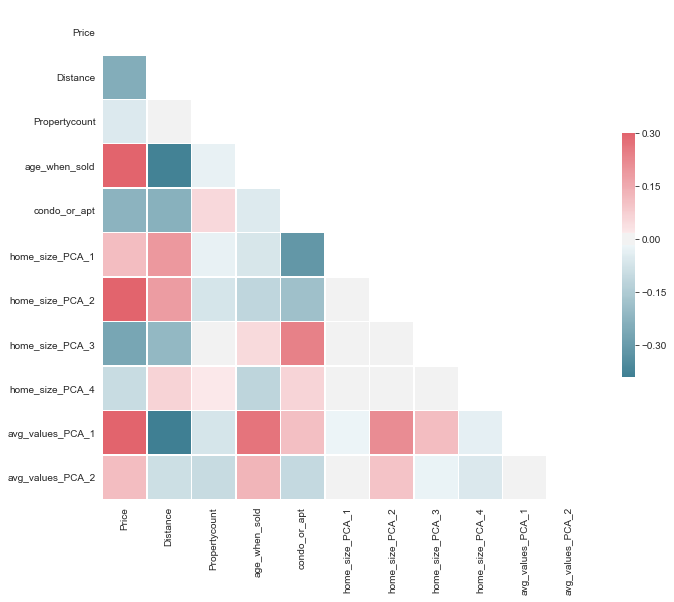

In [17]:
# Complete the processing of the working_df and compute the correlation matrix
working_df = features_PCAs(working_df)
working_df = working_df.dropna()
working_df.drop(['Postcode', 'Suburb', 'CouncilArea', 'Regionname', 'Method'], axis=1, inplace=True)

corr = working_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Graphs (post-cleaning of outliers)
There are more than a few outliers in the dataset, including an 800 year old house, a mansion with 20 bedrooms (more than the highest value in the "rooms" column, incidentally), and a couple of homes with 40,000 square meters of floorspace or >400,000 square meters of land. The price values get excessive, as well, with a number of homes over $6 million.

Once those outliers are cleared out, the graphs are quite illustrative.  (To see them with the outliers left in, simply insert a # in front of the 'clean_outliers' function.)

<function matplotlib.pyplot.show(*args, **kw)>

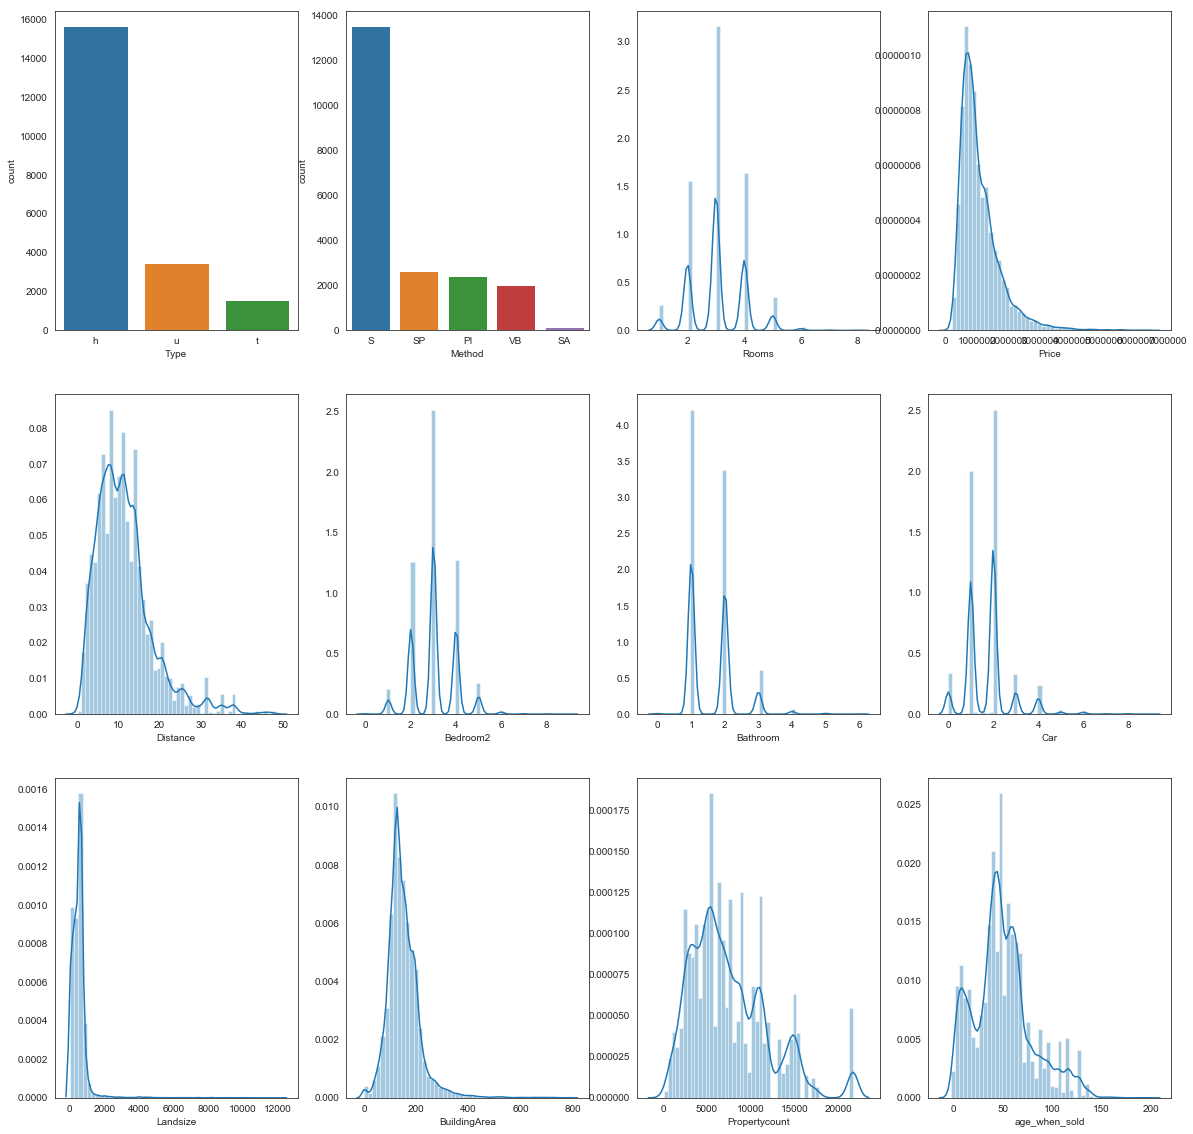

In [40]:
working_df = all_data_full.copy()
working_df = basic_clean(working_df)
working_df = clean_outliers(working_df) # <-- insert '#' here to view with outliers included
working_df = fillin_averages(working_df)
working_df['Postcode'] = working_df['Postcode'].astype(str)

plt.figure(figsize=(20,20))

plt.subplot(3, 4, 1)
sns.countplot(working_df['Type'])
plt.subplot(3, 4, 2)
sns.countplot(working_df['Method'])
plt.subplot(3, 4, 3)
sns.distplot(working_df['Rooms'])
plt.subplot(3, 4, 4)
sns.distplot(working_df['Price'])
plt.subplot(3, 4, 5)
sns.distplot(working_df['Distance'])
plt.subplot(3, 4, 6)
sns.distplot(working_df['Bedroom2'])
plt.subplot(3, 4, 7)
sns.distplot(working_df['Bathroom'])
plt.subplot(3, 4, 8)
sns.distplot(working_df['Car'])
plt.subplot(3, 4, 9)
sns.distplot(working_df['Landsize'])
plt.subplot(3,4,10)
sns.distplot(working_df['BuildingArea'])
plt.subplot(3,4,11) 
sns.distplot(working_df['Propertycount'])
plt.subplot(3,4,12)
sns.distplot(working_df['age_when_sold'])

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

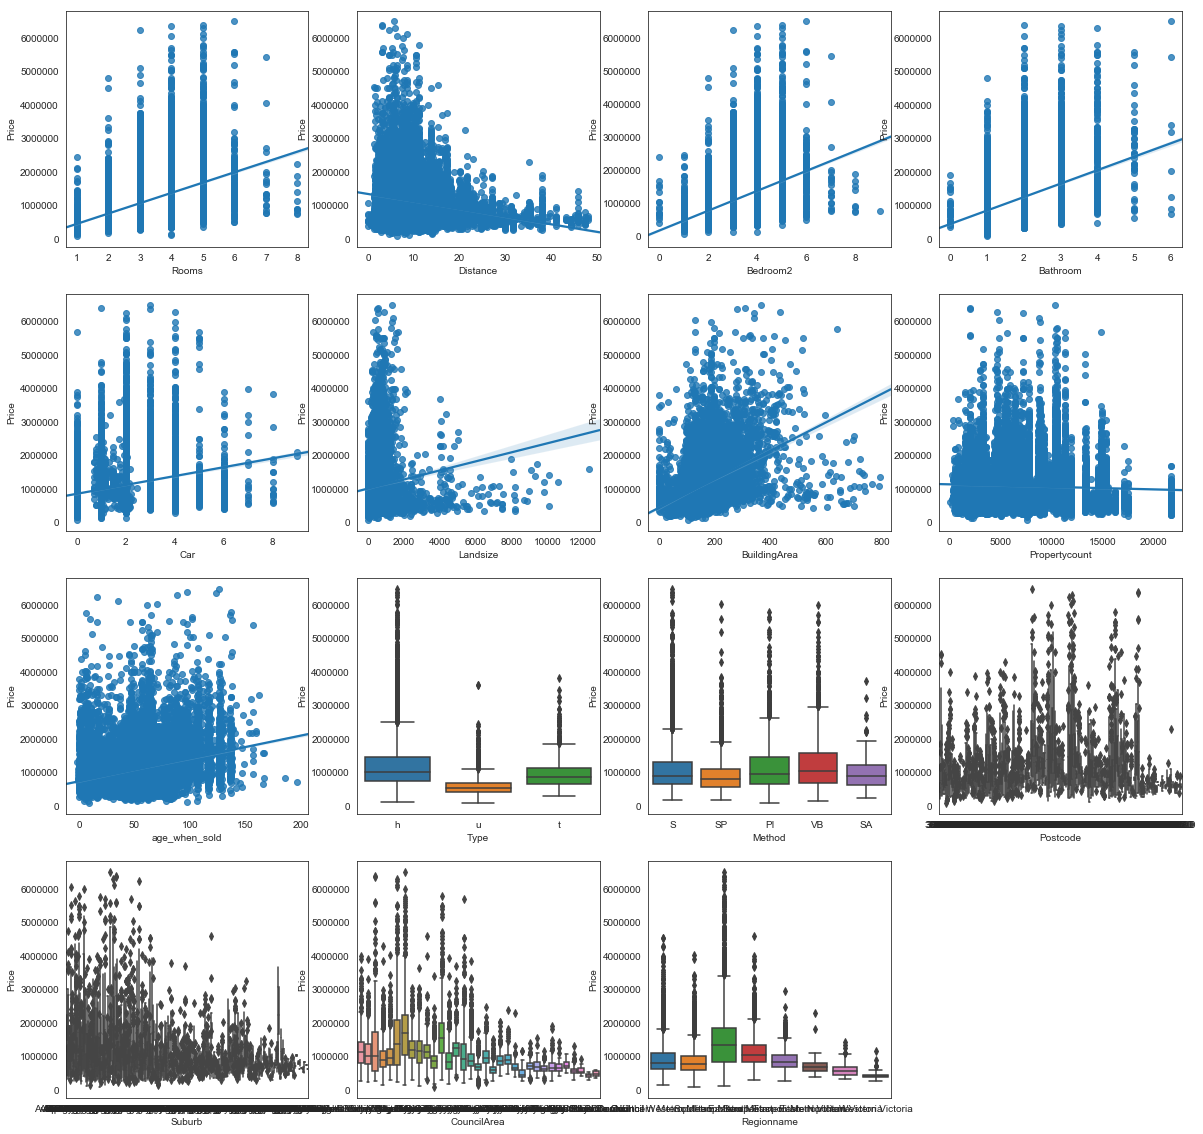

In [41]:
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
sns.regplot(x = 'Rooms', y = 'Price', data = working_df)
plt.subplot(4, 4, 2)
sns.regplot(x = 'Distance', y = 'Price', data = working_df)
plt.subplot(4, 4, 3)
sns.regplot(x = 'Bedroom2', y = 'Price', data = working_df)
plt.subplot(4, 4, 4)
sns.regplot(x = 'Bathroom', y = 'Price', data = working_df)
plt.subplot(4, 4, 5)
sns.regplot(x = 'Car', y = 'Price', data = working_df)
plt.subplot(4, 4, 6)
sns.regplot(x = 'Landsize', y = 'Price', data = working_df)
plt.subplot(4, 4, 7)
sns.regplot(x = 'BuildingArea', y = 'Price', data = working_df)
plt.subplot(4, 4, 8)
sns.regplot(x = 'Propertycount', y = 'Price', data = working_df)
plt.subplot(4, 4, 9)
sns.regplot(x = 'age_when_sold', y = 'Price', data = working_df)
plt.subplot(4,4,10)
sns.boxplot(x = 'Type', y = 'Price', data = working_df)
plt.subplot(4,4,11)
sns.boxplot(x = 'Method', y = 'Price', data = working_df)
plt.subplot(4,4,12)
sns.boxplot(x = 'Postcode', y = 'Price', data = working_df)
plt.subplot(4, 4, 13)
sns.boxplot(x = 'Suburb', y = 'Price', data = working_df)
plt.subplot(4, 4, 14)
sns.boxplot(x = 'CouncilArea', y = 'Price', data = working_df)
plt.subplot(4, 4, 15)
sns.boxplot(x = 'Regionname', y = 'Price', data = working_df)

plt.show

### Graphs of the fully-processed data


In [35]:
# Do the full processing on the data, and then visualize the results
working_df = all_data_full.copy()

working_df = basic_clean(working_df)
working_df = clean_outliers(working_df)
working_df = fillin_averages(working_df)
working_df = add_average_prices(working_df)
working_df = addin_features(working_df)
working_df = features_PCAs(working_df)

working_df = working_df.dropna()
working_df.drop(['Postcode', 'Suburb', 'CouncilArea', 'Regionname', 'Method'], axis=1, inplace=True)
working_df = pd.get_dummies(working_df)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<function matplotlib.pyplot.show(*args, **kw)>

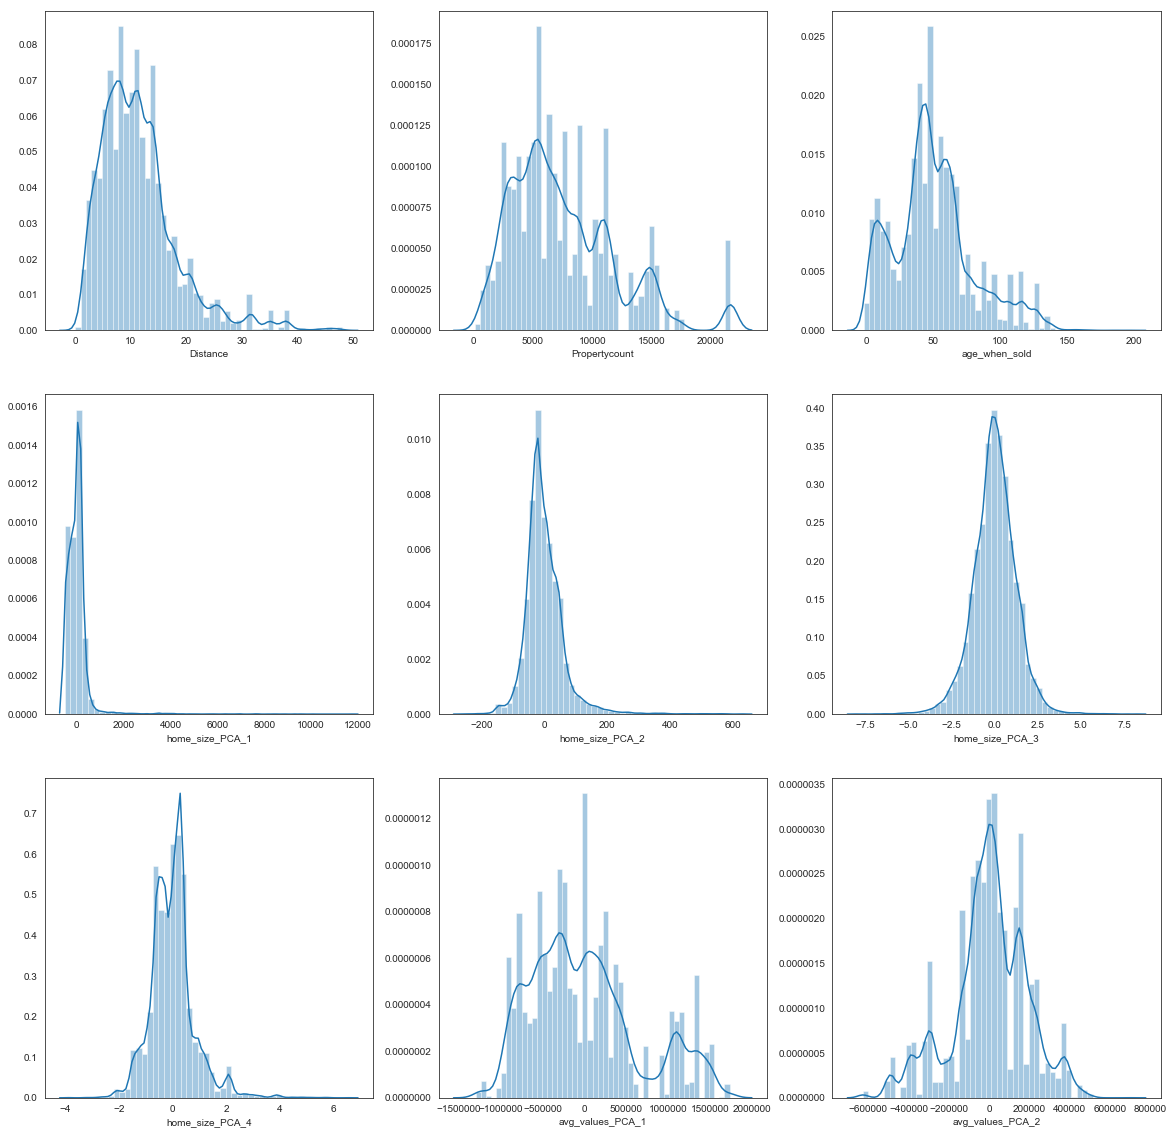

In [34]:
plt.figure(figsize=(20,20))

plt.subplot(3, 3, 1)
sns.distplot(working_df['Distance'])
plt.subplot(3, 3, 2)
sns.distplot(working_df['Propertycount'])
plt.subplot(3, 3, 3)
sns.distplot(working_df['age_when_sold'])
plt.subplot(3, 3, 4)
sns.distplot(working_df['home_size_PCA_1'])
plt.subplot(3, 3, 5)
sns.distplot(working_df['home_size_PCA_2'])
plt.subplot(3, 3, 6)
sns.distplot(working_df['home_size_PCA_3'])
plt.subplot(3, 3, 7)
sns.distplot(working_df['home_size_PCA_4'])
plt.subplot(3, 3, 8)
sns.distplot(working_df['avg_values_PCA_1'])
plt.subplot(3, 3, 9)
sns.distplot(working_df['avg_values_PCA_2'])

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

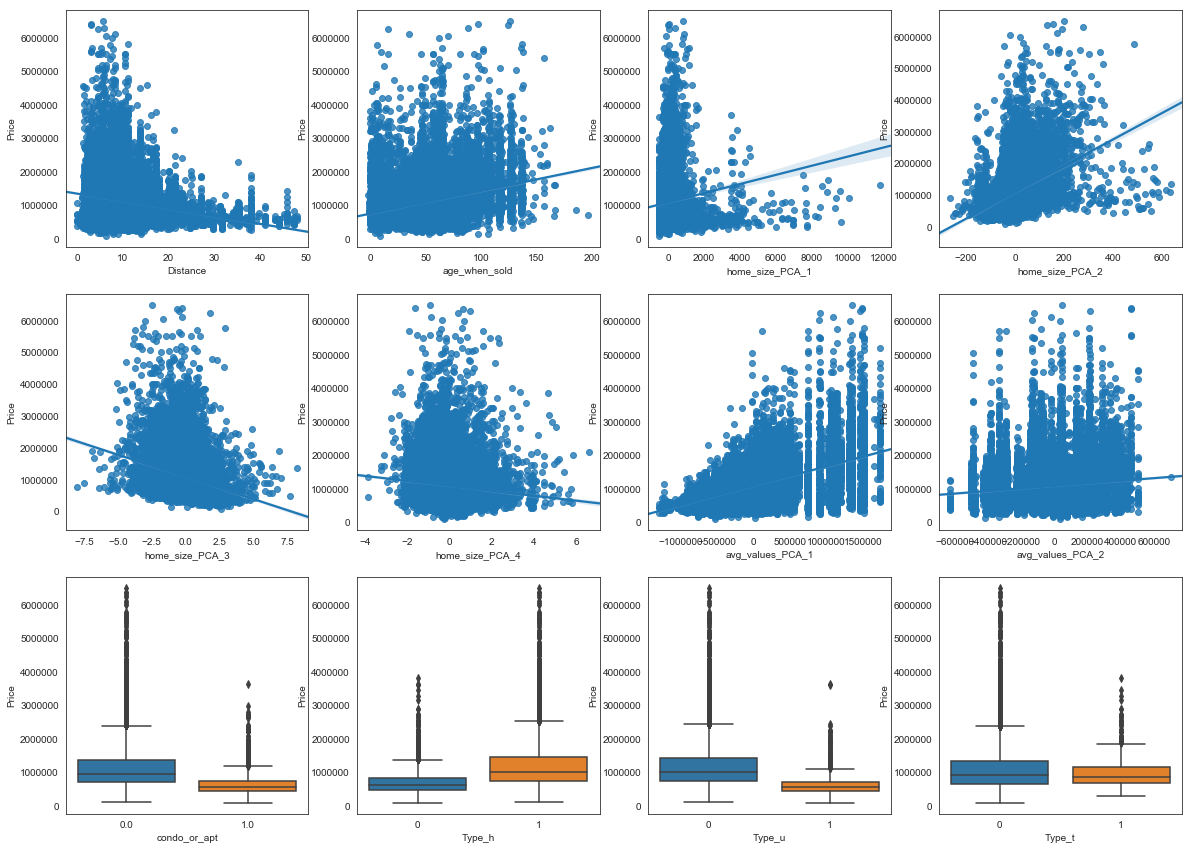

In [39]:
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
sns.regplot(x = 'Distance', y = 'Price', data = working_df)
plt.subplot(4, 4, 2)
sns.regplot(x = 'age_when_sold', y = 'Price', data = working_df)
plt.subplot(4, 4, 3)
sns.regplot(x = 'home_size_PCA_1', y = 'Price', data = working_df)
plt.subplot(4, 4, 4)
sns.regplot(x = 'home_size_PCA_2', y = 'Price', data = working_df)
plt.subplot(4, 4, 5)
sns.regplot(x = 'home_size_PCA_3', y = 'Price', data = working_df)
plt.subplot(4, 4, 6)
sns.regplot(x = 'home_size_PCA_4', y = 'Price', data = working_df)
plt.subplot(4, 4, 7)
sns.regplot(x = 'avg_values_PCA_1', y = 'Price', data = working_df)
plt.subplot(4, 4, 8)
sns.regplot(x = 'avg_values_PCA_2', y = 'Price', data = working_df)
plt.subplot(4, 4, 9)
sns.boxplot(x = 'condo_or_apt', y = 'Price', data = working_df)
plt.subplot(4,4,10)
sns.boxplot(x = 'Type_h', y = 'Price', data = working_df)
plt.subplot(4,4,11)
sns.boxplot(x = 'Type_u', y = 'Price', data = working_df)
plt.subplot(4,4,12)
sns.boxplot(x = 'Type_t', y = 'Price', data = working_df)

plt.show

### Run SelectKBest to identify important features

#### Baseline

In [46]:
# SelectKBest used on cleaned base data
working_df = all_data_full.copy()
working_df = basic_clean(working_df)
working_df = clean_outliers(working_df) # <-- insert '#' here to process with outliers included
working_df = fillin_averages(working_df)

# drop everything that can't be used for SelectKBest
working_df.drop(['Postcode', 'Suburb', 'CouncilArea', 'Regionname'], axis=1, inplace=True)

# Get Dummies for Type & Method
working_df = pd.get_dummies(working_df)

# Picking 5/10 SelectKBest features (replace k=5 with k=?? and delete the # from 6-10 to scale up)

X_best = SelectKBest(f_classif, k=5).fit_transform(
    working_df.drop(['Price'], axis=1), 
    working_df['Price'])
X_best_df = pd.DataFrame({
    'best_1':X_best[:,0],
    'best_2':X_best[:,1],
    'best_3':X_best[:,2],
    'best_4':X_best[:,3],
    'best_5':X_best[:,4],
    #'best_6':X_best[:,5],
   # 'best_7':X_best[:,6],
  #  'best_8':X_best[:,7],
 #   'best_9':X_best[:,8],
#    'best_10':X_best[:,9]
})

X_best_df.head(10)

,best_1,best_2,best_3,best_4,best_5
0,2.000,2.000,1.000,101.191,0.000
1,2.000,2.000,1.000,79.000,0.000
2,3.000,3.000,2.000,150.000,0.000
3,3.000,3.000,2.000,101.191,0.000
4,4.000,3.000,1.000,142.000,0.000
5,2.000,2.000,1.000,101.191,0.000
6,3.000,4.000,2.000,210.000,0.000
7,2.000,2.000,1.000,107.000,0.000
8,1.000,1.000,1.000,101.191,1.000
9,2.000,3.000,1.000,75.000,0.000


In [47]:
working_df.head(10)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Propertycount,age_when_sold,Type_h,Type_t,Type_u,Method_PI,Method_S,Method_SA,Method_SP,Method_VB
1,2,1480000.000,2.500,2.000,1.000,1.000,202.000,101.191,4019.000,73.431,1,0,0,0,1,0,0,0
2,2,1035000.000,2.500,2.000,1.000,0.000,156.000,79.000,4019.000,116.000,1,0,0,0,1,0,0,0
4,3,1465000.000,2.500,3.000,2.000,0.000,134.000,150.000,4019.000,117.000,1,0,0,0,0,0,1,0
5,3,850000.000,2.500,3.000,2.000,1.000,94.000,101.191,4019.000,73.431,1,0,0,1,0,0,0,0
6,4,1600000.000,2.500,3.000,1.000,2.000,120.000,142.000,4019.000,2.000,1,0,0,0,0,0,0,1
10,2,941000.000,2.500,2.000,1.000,0.000,181.000,101.191,4019.000,73.431,1,0,0,0,1,0,0,0
11,3,1876000.000,2.500,4.000,2.000,0.000,245.000,210.000,4019.000,106.000,1,0,0,0,1,0,0,0
14,2,1636000.000,2.500,2.000,1.000,2.000,256.000,107.000,4019.000,126.000,1,0,0,0,1,0,0,0
17,1,300000.000,2.500,1.000,1.000,1.000,0.000,101.191,4019.000,73.431,0,0,1,0,1,0,0,0
18,2,1097000.000,2.500,3.000,1.000,2.000,220.000,75.000,4019.000,116.000,1,0,0,0,1,0,0,0


#### Analysis
Rooms, Bedroom2, Bathroom, BuildingArea, and Type_u seem to be the winners.  Not much of a surprise, really, considering how important the size of a home is to its value.  What _is_ interesting is the fact that being a duplex is in the top 5 factors for determining the price, at least in this set of features.

#### With average geographic values added in

In [49]:
# SelectKBest used on cleaned base data
working_df = all_data_full.copy()
working_df = basic_clean(working_df)
working_df = clean_outliers(working_df) # <-- insert '#' here to process with outliers included
working_df = fillin_averages(working_df)
working_df = add_average_prices(working_df)
working_df = addin_features(working_df)

# drop everything that can't be used for SelectKBest
working_df.drop(['Postcode', 'Suburb', 'CouncilArea', 'Regionname'], axis=1, inplace=True)

# Get Dummies for Type & Method
working_df = pd.get_dummies(working_df)

# Picking 5/10 SelectKBest features (replace k=5 with k=?? and delete the # from 6-10 to scale up)

X_best = SelectKBest(f_classif, k=5).fit_transform(
    working_df.drop(['Price'], axis=1), 
    working_df['Price'])
X_best_df = pd.DataFrame({
    'best_1':X_best[:,0],
    'best_2':X_best[:,1],
    'best_3':X_best[:,2],
    'best_4':X_best[:,3],
    'best_5':X_best[:,4],
    #'best_6':X_best[:,5],
   # 'best_7':X_best[:,6],
  #  'best_8':X_best[:,7],
 #   'best_9':X_best[:,8],
#    'best_10':X_best[:,9]
})

X_best_df.head(10)

,best_1,best_2,best_3,best_4,best_5
0,2.000,1086034.247,1086034.247,1164772.775,0.000
1,2.000,1086034.247,1086034.247,1164772.775,0.000
2,3.000,1086034.247,1086034.247,1164772.775,0.000
3,3.000,1086034.247,1086034.247,1164772.775,0.000
4,4.000,1086034.247,1086034.247,1164772.775,0.000
5,2.000,1086034.247,1086034.247,1164772.775,0.000
6,3.000,1086034.247,1086034.247,1164772.775,0.000
7,2.000,1086034.247,1086034.247,1164772.775,0.000
8,1.000,1086034.247,1086034.247,1164772.775,1.000
9,2.000,1086034.247,1086034.247,1164772.775,0.000


In [50]:
working_df.head(10)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Propertycount,age_when_sold,suburb_average_price,postal_average_price,council_average_price,region_average_price,condo_or_apt,Type_h,Type_t,Type_u,Method_PI,Method_S,Method_SA,Method_SP,Method_VB
1,2,1480000.000,2.500,2.000,1.000,1.000,202.000,101.191,4019.000,73.431,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,1,0,0,0
2,2,1035000.000,2.500,2.000,1.000,0.000,156.000,79.000,4019.000,116.000,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,1,0,0,0
4,3,1465000.000,2.500,3.000,2.000,0.000,134.000,150.000,4019.000,117.000,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,0,0,1,0
5,3,850000.000,2.500,3.000,2.000,1.000,94.000,101.191,4019.000,73.431,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,1,0,0,0,0
6,4,1600000.000,2.500,3.000,1.000,2.000,120.000,142.000,4019.000,2.000,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,0,0,0,1
10,2,941000.000,2.500,2.000,1.000,0.000,181.000,101.191,4019.000,73.431,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,1,0,0,0
11,3,1876000.000,2.500,4.000,2.000,0.000,245.000,210.000,4019.000,106.000,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,1,0,0,0
14,2,1636000.000,2.500,2.000,1.000,2.000,256.000,107.000,4019.000,126.000,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,1,0,0,0
17,1,300000.000,2.500,1.000,1.000,1.000,0.000,101.191,4019.000,73.431,1086034.247,1086034.247,1164772.775,902728.582,1.000,0,0,1,0,1,0,0,0
18,2,1097000.000,2.500,3.000,1.000,2.000,220.000,75.000,4019.000,116.000,1086034.247,1086034.247,1164772.775,902728.582,0.000,1,0,0,0,1,0,0,0


#### Analysis
With all of the area values added in, Rooms, suburb_average_price, postal_average_price, council_average_price, and (again) Type_u seem to be the winners.  Again, this isn't very surprising, given that _where_ the house is sets its price as much or more than its size.  

Now, however, the Apartment/Condo binary feature replaces the Duplex binary (likely a result of it grabbing more 0-land-area homes than were categorized as duplexes). Which, now that I think on it, isn't entirely surprising - you're not paying for the _land_ of an apartment/condo/duplex, meaning it sells for less than an equivalent square footage of a house with a yard, so places with equivalent BuildingArea but lower Landsize should be somewhat lower priced.

To make the model perform better, we need to make PCAs representing both the size and location of the home.

## Working Dataset creation and processing

In [51]:

# Create a working dataframe so that operations can be performed on any dataframe by switching out a single variable.
working_df = all_data_full.copy()

# Other options: all_data_full  half_data_full  quarter_data_full  tenth_data_full  hundreth_data_full

# Run the data-preparation functions on it.
working_df = basic_clean(working_df)
working_df = clean_outliers(working_df)
working_df = fillin_averages(working_df)
working_df = add_average_prices(working_df)
working_df = addin_features(working_df)
working_df = features_PCAs(working_df)

working_df = working_df.dropna()

working_df.drop(['Postcode', 'Suburb', 'CouncilArea', 'Regionname', 'Method'], axis=1, inplace=True)

# Get dummies for the remaining non-numeric features in the dataset
working_df = pd.get_dummies(working_df)

# delete the '#' sign below to be able to skim through the resulting dataframe
#working_df.head(10)

## Preparing sample datasets for use in the model(s)

In [53]:
# create samples for training & testing
training_fraction = .8

training_X = working_df.sample(frac=training_fraction, random_state=10)
testing_X = working_df.drop(training_X.index)


# separate the Price feature out into Y datasets
training_Y = training_X['Price']
testing_Y = testing_X['Price']

# dropping the Price feature from the X datasets so that the model isn't able to cheat
training_X.drop('Price', axis=1, inplace=True)
testing_X.drop('Price', axis=1, inplace=True)
print(" ")

## Running an assortment of models to find the most successful

In [54]:
# Random Forest model
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(training_X,training_Y)
print('Random Forest results:')
print(' ')
accuracy_report(testing_X, testing_Y, rfr, 1)

Random Forest results:
 
Explained Variance Score: 0.805168588733453
Mean Absolute Error: 165190.72931558007
Mean Squared Error: 76991615459.67668
Median Absolute Error: 96417.5
R-squared: 0.8050503094988385
 
Model cross-valuation:
[0.73388027 0.71144618 0.80570453 0.77378092 0.814956  ]


In [62]:
# Decision Tree

dtree = tree.DecisionTreeRegressor()
dtree.fit(training_X,training_Y)
print('Decision Tree results:')
print(' ')
accuracy_report(testing_X, testing_Y, dtree, 1)

Decision Tree results:
 
Explained Variance Score: 0.6070115568634118
Mean Absolute Error: 229996.568269286
Mean Squared Error: 155226510054.8412
Median Absolute Error: 130000.0
R-squared: 0.6069525244782569
 
Model cross-valuation:
[0.45190465 0.41049124 0.59453717 0.53589548 0.55145403]


In [56]:
# Gradient Boosting Regression

gbr = ensemble.GradientBoostingRegressor(n_estimators=200)
gbr.fit(training_X,training_Y)
print('GBR results:')
print(' ')
accuracy_report(testing_X, testing_Y, gbr, 1)


GBR results:
 
Explained Variance Score: 0.8037560976818725
Mean Absolute Error: 172959.08466810247
Mean Squared Error: 77524517199.4362
Median Absolute Error: 108078.87210340798
R-squared: 0.8037009543955148
 
Model cross-valuation:
[0.75461976 0.71263979 0.80624744 0.78346329 0.82156632]


In [57]:
# KNN

neighbors = KNeighborsRegressor()
neighbors.fit(training_X,training_Y)
print('KNN results:')
print(' ')
accuracy_report(testing_X, testing_Y, neighbors, 1)

KNN results:
 
Explained Variance Score: 0.6201831488481236
Mean Absolute Error: 225027.44323281062
Mean Squared Error: 150041352060.5881
Median Absolute Error: 126400.0
R-squared: 0.6200818105718664
 
Model cross-valuation:
[0.3503039  0.33190362 0.46635069 0.47194043 0.60320984]


In [58]:
# Lasso Regression

lasso = linear_model.Lasso()
lasso.fit(training_X,training_Y)
print('Lasso Regression results:')
print(' ')
accuracy_report(testing_X, testing_Y, lasso, 1)

Lasso Regression results:
 
Explained Variance Score: 0.6717248385497022
Mean Absolute Error: 241435.6106012941
Mean Squared Error: 129662138551.82468
Median Absolute Error: 175402.83610914415
R-squared: 0.671683810899698
 
Model cross-valuation:
[0.65628578 0.58929543 0.66695492 0.68209591 0.69526299]


In [59]:
# Ridge Regression

ridge = linear_model.Ridge()
ridge.fit(training_X,training_Y)
print('Ridge Regression results:')
print(' ')
accuracy_report(testing_X, testing_Y, ridge, 1)

Ridge Regression results:
 
Explained Variance Score: 0.6717248612679889
Mean Absolute Error: 241433.273724022
Mean Squared Error: 129662136212.6939
Median Absolute Error: 175368.83724857122
R-squared: 0.6716838168225874
 
Model cross-valuation:
[0.65630085 0.58930205 0.66695766 0.68209149 0.69525911]


In [60]:
# Naive Bayes

bnb = BernoulliNB()
bnb.fit(training_X,training_Y)
print('Naive Bayes results:')
print(' ')
accuracy_report(testing_X, testing_Y, bnb, 1)

Naive Bayes results:
 
Explained Variance Score: 0.42426100045515425
Mean Absolute Error: 322054.42002412543
Mean Squared Error: 231225540146.94305
Median Absolute Error: 224500.0
R-squared: 0.4145161493433126
 
Model cross-valuation:


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.01037218 0.01101322 0.01365706 0.02524272 0.0259434 ]


#### Analysis

Naive Bayes is right out, no surprise for such a simple model applied to such a complex task.  

Random Forest and Gradient Boosting Regression are tied for the top two models, due to their ability to take multiple factors into consideration and guess a more-correct outcome. 

Lasso and Ridge regression were both adequate but not close enough to the level of the two ensemble models, likely due to the high variability of house values based on location, size, AND whether they were condos or had surrounding land area giving the models too much complexity to chew on.  

KNN and Decision Tree also failed to measure up, likely due to KNN's need for a relatively clean gradient between values (which this dataset does not have), and Decision Tree's relative simplicity for an ensemble model.

Going forward, I'll be using GBR, due to its noticeably faster processing time compared to RFR.

## Perform GridSearchCV to identify optimal parameters

In [70]:
# Gridsearch CV for the GBR algorithm

grid_param_GBR = {
    'max_features': [.9,'sqrt','log2',None],
    'max_depth': [4,5,6,7,8],
    'criterion': ['friedman_mse', 'mse'],
    'n_estimators' : [150,160,170,180,190]
}

grid_search_GBR = GridSearchCV(estimator = gbr,  
                              param_grid = grid_param_GBR,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_GBR.fit(testing_X, testing_Y)
print('GBR recommended parameters:')
print(grid_search_GBR.best_params_)
print(' ')

GBR recommended parameters:
{'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 160}
 


#### Analysis
criterion = 'friedman_mse', max_depth = 5, max_features = 'sqrt', n_estimators = 160 (or 170, it varies betweens runs) seems to be the winner here.  Let's try it out.

## Running the model using the optimized parameters

In [81]:
# Gradient Boosting Regression, optimized parameters

gbr = ensemble.GradientBoostingRegressor(criterion = 'friedman_mse', 
                                         max_depth = 5, 
                                         max_features = 'sqrt', 
                                         n_estimators = 160)
gbr.fit(training_X,training_Y)
print('GBR results:')
print(' ')
accuracy_report(testing_X, testing_Y, gbr, 1)


GBR results:
 
Explained Variance Score: 0.8193793206882295
Mean Absolute Error: 164991.39496907147
Mean Squared Error: 71359790110.0155
Median Absolute Error: 99912.69901062979
R-squared: 0.8193105974836784
 
Model cross-valuation:
[0.77562972 0.72828363 0.83197887 0.78297184 0.8187685 ]


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


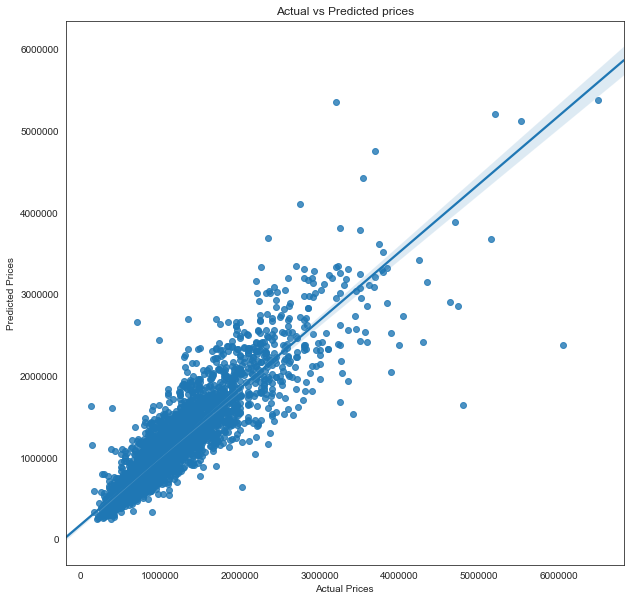

In [80]:
# Plot of predicted values (Y) versus actual values (X)

plt.figure(figsize=(10,10))
sns.regplot(testing_Y, gbr.predict(testing_X))
plt.title('Actual vs Predicted prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

## Results
Optimizing the model parameters got us an extra .016 on the R squared for the model, putting it at ~81% accuracy, give or take a percent.  As we can tell from the graph, the model's got a reasonably even chance of over- and under-shooting on a house's price, so there are no significant issues with bias towards or against a particular price level.  However, it's worth noting that the higher the house's expected price goes, the more uncertainty there should be about the estimate's accuracy, given how little evidence the model has to base its estimates on for houses over $2 million.  

Overall, GBR seems to perform very well in estimating the value of a home, given the complexities of location, size, and extras that go into such a calculation.  It's ability to triangulate on the "correct" answer via gradient boosting, combined with the collective effects of a 'forest' of decision trees giving their ensemble answer to the problem, makes for a decent approximation of a realtor's intuition.  (Maybe even a less biased one.  I'd be interested in seeing the results of trained realtors going through and estimating these homes' final sell price, and how/whether the model compares with them.)